# CALSNIC Dataset

In [1]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

date_cols = ['Visit_Date', 'CNSLS_Date', 'Date of death', 'ALSFRS_Date', 'SymptomOnset_Date']
df = pd.read_csv(Path.joinpath(cfg.CALSNIC_DATA_DIR, 'data.csv'), index_col=0, parse_dates=date_cols)
event_cols = ['Event_Speech', 'Event_Swallowing', 'Event_Handwriting', 'Event_Walking', 'Event_Death']

In [2]:
df.columns

Index(['PSCID', 'Visit', 'Symptom_Duration', 'Visit_details', 'Visit_Date',
       'CNSLS_Date', 'CNSLS_TotalScore', 'Status', 'Date of death',
       'Cause of death', 'ALSFRS_Date', 'ALSFRS_1_Speech',
       'ALSFRS_2_Salivation', 'ALSFRS_3_Swallowing', 'ALSFRS_Bulbar_Subscore',
       'ALSFRS_4_Handwriting', 'ALSFRS_GastrostomyPresent',
       'ALSFRS_5_Cuttingfood&handlingutensils', 'ALSFRS_6_Dressing&hygiene',
       'ALSFRS_Fine Motor_subscore', 'ALSFRS_7_Turninginbed',
       'ALSFRS_8_Walking', 'ALSFRS_9_Climbingstairs',
       'ALSFRS_Gross Motor_subscore', 'ALSFRS_10_Dyspnea',
       'ALSFRS_11_Orthopnea', 'ALSFRS_12_RespiratoryInsufficiency',
       'ALSFRS_Breathing_Subscore', 'ALSFRS_TotalScore',
       'TAP_Trial1RightFinger', 'TAP_Trial1LeftFinger',
       'TAP_Trial2RightFinger', 'TAP_Trial2leftFinger', 'TAP_Trial1RightFoot',
       'TAP_Trial1LeftFoot', 'TAP_Trial2RightFoot', 'TAP_Trial2LeftFoot',
       'TAP_Fingertapping_Right_avg', 'TAP_Fingertapping_Left_avg',
    

In [3]:
for event_col in event_cols:
    obs_arr = np.array(df[event_col])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 152
Number of censored/uncensored: 122.0/30.0
80.26% of records are censored

Number of samples: 152
Number of censored/uncensored: 123.0/29.0
80.92% of records are censored

Number of samples: 152
Number of censored/uncensored: 121.0/31.0
79.61% of records are censored

Number of samples: 152
Number of censored/uncensored: 63.0/89.0
41.45% of records are censored

Number of samples: 152
Number of censored/uncensored: 82/70
53.95% of records are censored



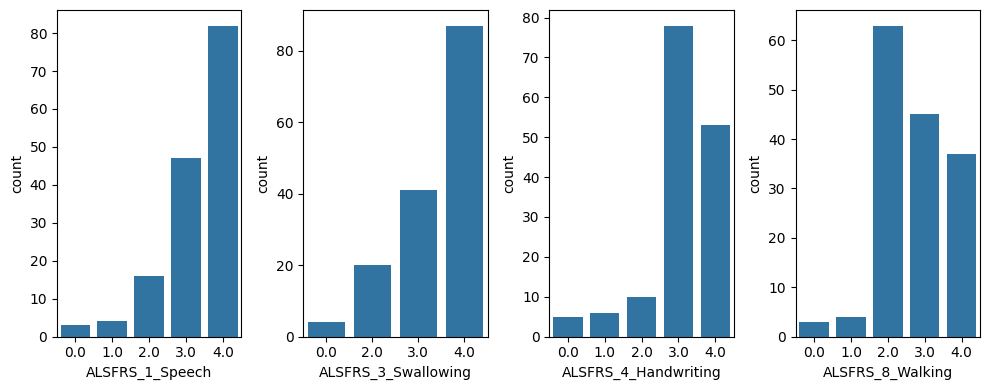

In [4]:
# Plot ALSFRS distribution
alsfrs_cols = ['ALSFRS_1_Speech', 'ALSFRS_3_Swallowing', 'ALSFRS_4_Handwriting', 'ALSFRS_8_Walking']
fig, axs = plt.subplots(ncols=len(alsfrs_cols), figsize=(10,4))
for i, col in enumerate(alsfrs_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
plt.tight_layout()
plt.show()

In [5]:
# Count number of occurances
threshold = 2
for col in alsfrs_cols:
    n_samles_under, n_samples_over = len(df.loc[df[col] <= threshold]), len(df.loc[df[col] > threshold])
    print(f'{n_samles_under} are under {threshold}, {n_samples_over} are over {threshold}')

23 are under 2, 129 are over 2
24 are under 2, 128 are over 2
21 are under 2, 131 are over 2
70 are under 2, 82 are over 2


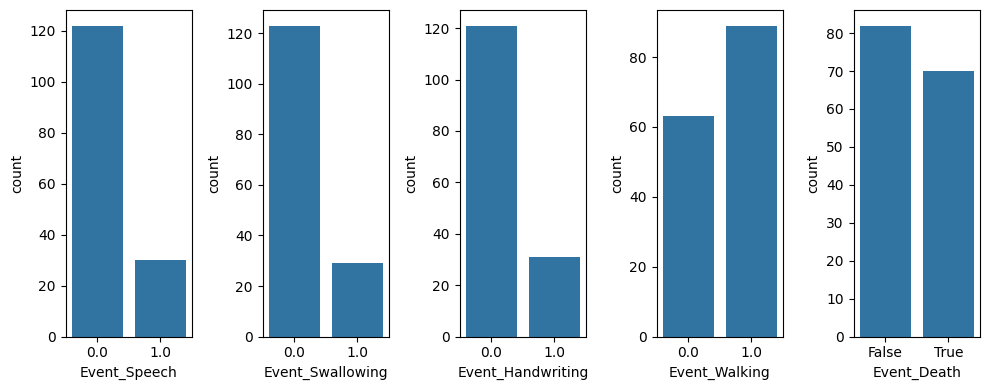

In [6]:
fig, axs = plt.subplots(ncols=len(event_cols), figsize=(10,4))
for i, col in enumerate(event_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
plt.tight_layout()
plt.show()

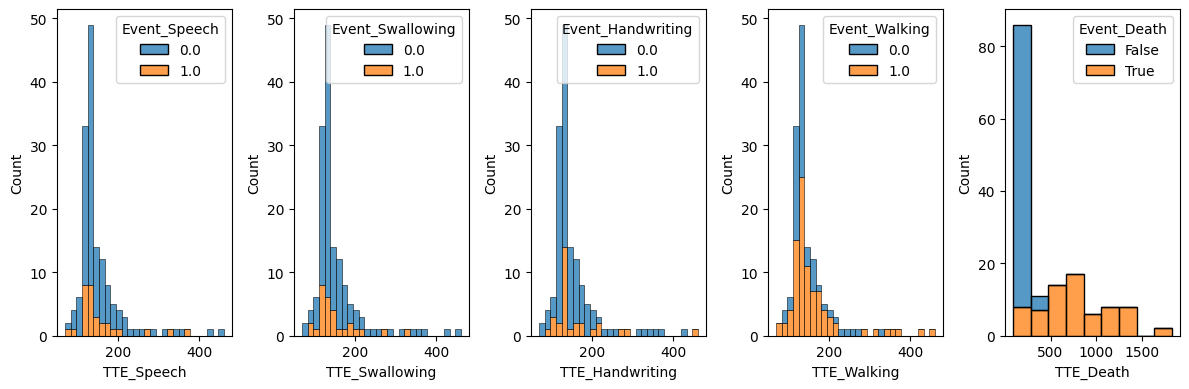

In [7]:
fig, axs = plt.subplots(ncols=len(event_cols), figsize=(12,4))
event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking', 'Death']
for i, col in enumerate(event_names):
    event = df[[f'TTE_{col}', f'Event_{col}']]
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'Event_{col}', multiple="stack", bins="auto", ax=axs[i])
plt.tight_layout()
plt.show()